In [8]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as torch_d
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

from pcs_gumbel_softmax import tx
from pcs_gumbel_softmax import helper as hlp
from pcs_gumbel_softmax import utils
from pcs_gumbel_softmax import autoencoder as ae

# Parameters

In [9]:
# Channel Parameters
chParam = utils.AttrDict()
chParam.M = 64
chParam.SNR_db = [3, 7, 12, 30]
# chParam.SNR_db = [0, 5, 12, 18, 30]

# Auto-Encoder Parameters
aeParam = utils.AttrDict()
aeParam.temperature = 1
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 2
aeParam.nFeaturesEnc  = 128
aeParam.nFeaturesDec  = 128

# Training Parameters
trainingParam = utils.AttrDict()
trainingParam.nBatches      = 8
trainingParam.batchSize     = 8*chParam.M
trainingParam.learningRate  = 0.005
trainingParam.iterations    = 31
trainingParam.displayStep   = 5

## Helper Functions

In [10]:
def p_norm(p, x, fun=lambda x: torch.pow(torch.abs(x), 2)):
    return torch.sum(p * fun(x))

In [11]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return F.one_hot(torch.argmax(input, axis=-1), chParam.M)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [12]:
def r2c(x):
    return x.type(torch.complex64)

In [13]:
def plot_2D_PDF(const, pmf, db):
    s = pmf * 1600
    plt.figure(figsize=(5, 5))
    plt.scatter(const.real, const.imag, s, c="r")
    plt.title(f'SNR = {db} dB')
    plt.grid()
    plt.show()

## Training Loop

---SNR = 3 dB---


C:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 0: Loss = -3.3630 - always 1: 1.0
epoch 5: Loss = -4.1478 - always 1: 1.0
epoch 10: Loss = -4.1496 - always 1: 1.0
epoch 15: Loss = -4.1299 - always 1: 1.0
epoch 20: Loss = -4.1954 - always 1: 1.0
epoch 25: Loss = -4.1043 - always 1: 1.0
epoch 30: Loss = -4.0634 - always 1: 1.0
Power should always be one: tensor(1.0000, grad_fn=<SumBackward0>)


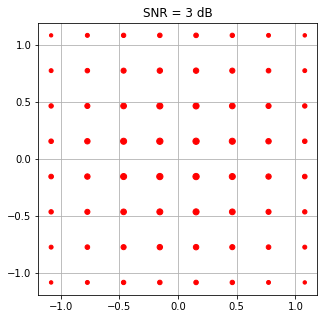

---SNR = 7 dB---
epoch 0: Loss = -3.3623 - always 1: 1.0
epoch 5: Loss = -4.9927 - always 1: 1.0
epoch 10: Loss = -5.1447 - always 1: 1.0
epoch 15: Loss = -5.1380 - always 1: 1.0
epoch 20: Loss = -5.0897 - always 1: 1.0
epoch 25: Loss = -5.1486 - always 1: 1.0
epoch 30: Loss = -5.0366 - always 1: 1.0
Power should always be one: tensor(1.0000, grad_fn=<SumBackward0>)


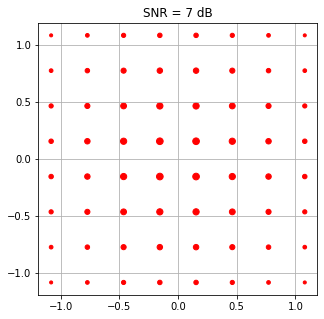

---SNR = 12 dB---
epoch 0: Loss = -3.4930 - always 1: 1.0
epoch 5: Loss = -6.4081 - always 1: 1.0
epoch 10: Loss = -6.3919 - always 1: 1.0
epoch 15: Loss = -6.5060 - always 1: 1.0
epoch 20: Loss = -6.3918 - always 1: 1.0
epoch 25: Loss = -6.4720 - always 1: 1.0
epoch 30: Loss = -6.5921 - always 1: 1.0
Power should always be one: tensor(1., grad_fn=<SumBackward0>)


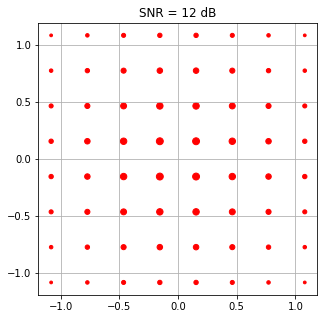

---SNR = 30 dB---
epoch 0: Loss = -3.6192 - always 1: 1.0
epoch 5: Loss = -7.6581 - always 1: 1.0
Power should always be one: tensor(1., grad_fn=<SumBackward0>)


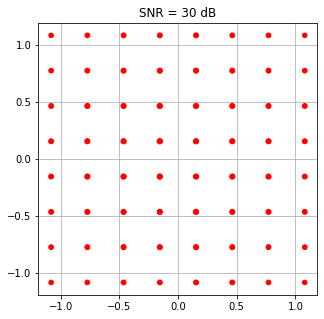

In [14]:
enc_inp = torch.tensor([[1]], dtype=torch.float)

for (k, SNR_db) in enumerate(chParam.SNR_db):
    print(f'---SNR = {chParam.SNR_db[k]} dB---')

    # Initialize network
    encoder = ae.Encoder_Stark(in_features=1, width=aeParam.nFeaturesEnc, out_features=chParam.M)
    decoder = ae.Decoder_Stark(in_features=2, width=aeParam.nFeaturesDec, out_features=chParam.M)
    CEloss = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=trainingParam.learningRate)

    # Training loop
    for j in range(trainingParam.iterations):
        for i in range (trainingParam.nBatches):
            # first generate the distribution
            s_logits = encoder(enc_inp)
            g_dist = torch_d.Gumbel(loc=torch.tensor([0.]), scale=torch.tensor([1.])) # create Gumbel dist
            g = torch.squeeze(g_dist.sample(sample_shape=[trainingParam.batchSize, chParam.M]))
            s_bar = F.softmax(input=((g + s_logits) / aeParam.temperature), dim=1)
            s = STEFunction.apply(s_bar) # straight through estimator

            # normalization & Modulation
            p_s = F.softmax(s_logits, dim=1)
            constellation = tx.qammod(chParam.M)
            constellation_t = torch.tensor(constellation, dtype=torch.cfloat)
            norm_factor = torch.rsqrt(p_norm(p_s, constellation_t))
            norm_constellation = torch.mul(constellation_t, r2c(norm_factor))
            x = torch.matmul(r2c(s), torch.transpose(input=norm_constellation, dim0=0, dim1=1))
            should_always_be_one = p_norm(p_s, norm_constellation)

            # Channel
            noise_cpx = torch.complex(torch.randn(x.shape), torch.randn(x.shape))
            sigma2 = torch.tensor(1) / hlp.dB2lin(SNR_db, 'dB')  # 1 corresponds to the Power
            noise_snr = r2c(torch.sqrt(sigma2)) * torch.rsqrt(torch.tensor(2)) * noise_cpx
            # https://stats.stackexchange.com/questions/187491/why-standard-normal-samples-multiplied-by-sd-are-samples-from-a-normal-dist-with

            y = torch.add(x, noise_snr)

            # demodulator
            y_vec = hlp.complex2real(torch.squeeze(y))
            dec = decoder(y_vec)


            # loss
            loss = CEloss(dec, s.type(torch.float).detach())
            entropy_S = -p_norm(p_s, p_s, lambda x: torch.log2(x))
            loss_hat = loss - entropy_S

            optimizer.zero_grad()
            loss_hat.backward()
            optimizer.step()

        # Printout and visualization
        if j % int(trainingParam.displayStep) == 0:
            print(f'epoch {j}: Loss = {loss_hat.detach().numpy() / np.log(2) :.4f} - always 1: {should_always_be_one :.2}')
        if loss_hat.detach().numpy() / np.log(2) < -8:
            break

    # Data for the plots
    p_s_t = F.softmax(encoder(enc_inp), dim=1)
    p_s = p_s_t.detach().numpy()[0]
    constellation = tx.qammod(chParam.M)  # ToDo: returns a complex
    constellation_t = torch.tensor(constellation, dtype=torch.cfloat)
    norm_factor = torch.rsqrt(p_norm(p_s_t, constellation_t))  # ToDo: returns a real
    norm_constellation = r2c(norm_factor) * constellation_t
    #print(p_s)
    print('Power should always be one:', p_norm(p_s_t, norm_constellation))
    plot_2D_PDF(constellation, p_s, SNR_db)